In [3]:
import pandas as pd
import json
import numpy as np
import nltk 
import string
import re
import os
import ast

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\72809\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\72809\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Load Json Data

In [5]:
# Read the entire file into a python array
with open('tweets.json', 'rb') as f:
    data = f.readlines()

In [6]:
# Show the attributes in a Tweet object
new_data = json.loads(data[0])
print(new_data)

{'_id': {'$oid': '5e6077325d8ebba864ce03e7'},
 'created_at': {'$date': '2020-03-05T03:51:09.000Z'},
 'id': {'$numberLong': '1235412509017989125'},
 'id_str': '1235412509017989125',
 'text': 'RT @KingGeorge: Massive follower #Giveaway from myself + @CORSAIR. #Ad \n\nTo enter:\n🔗 Click here: https://t.co/9R4COF9yQF\n\nBonus entries:\n💬…',
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 3327978974,
  'id_str': '3327978974',
  'name': 'RJ',
  'screen_name': 'rj101701',
  'location': None,
  'url': None,
  'description': 'The hardest choices require the strongest wills-Thanos',
  'translator_type': 'none',
  'protected': False,
  'verified': False,
  'followers_count': 22,
  'friends_count': 458,
  'listed_count': 0,
  'favourites_count': 64

In [7]:
print(type(new_data))
print(new_data.keys())

<class 'dict'>
dict_keys(['_id', 'created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'possibly_sensitive', 'filter_level', 'lang', 'timestamp_ms'])


# 2. Extract Text and Hashtag

In [8]:
def GetTextAndHashtag(new_data):
    # Get hashtags in a Tweet Object
    ht = new_data['entities']['hashtags']
    ht_list = []
    for hat in ht:
    #     print(hat)
        ht_list.append(hat['text'])

    # Get text in a Tweet Object
    text = new_data['text']
    return ht_list, text

# print(ht_list,'\n', text)

In [9]:
total_ht = []
total_text = []
for dt in data:
    data_dict = json.loads(dt)
    ht_list,text = GetTextAndHashtag(data_dict)
    total_ht.append(ht_list)
    total_text.append(text)

total_dict = {'text':total_text,
             'hashtags':total_ht}
df = pd.DataFrame(total_dict)
df

,text,hashtags
0,RT @KingGeorge: Massive follower #Giveaway fro...,"[Giveaway, Ad]"
1,RT @Stray_Kids: [BuzzFeed]\nStray Kids(스트레이 키즈...,"[StrayKids, 스트레이키즈]"
2,Opportunities for Clinical Manager (RN) in Pan...,"[Panama, CTNA, LPN, Nurse, NursingJobs, Panama..."
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,[ON]
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,[Karnan]
...,...,...
146222,Standing alone in an empty #chicago subway. @ ...,[chicago]
146223,So lucky to be spending more time with my favo...,"[sunshine, beachwalk]"
146224,"current weather in Rialto: scattered clouds, 5...",[]
146225,"current weather in La Verne: scattered clouds,...",[]


In [10]:
# Remove the text without hashtags
noht_idx = []
for idx in range(df.shape[0]):
    if len(df['hashtags'][idx]) != 1:
        noht_idx.append(idx)
df0 = df.drop(noht_idx)
df0

,text,hashtags
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,[ON]
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,[Karnan]
7,RT @Amandatammi: My favorite part of my Wednes...,[Chicagopd]
8,RT @Twins: A sight for sore eyes 😍 #MNTwins ht...,[MNTwins]
10,A new #superfan is enjoying what I've been po...,[superfan]
...,...,...
146200,Cameroon confirms first two coronavirus cases ...,[Nigeriatunes]
146204,Okay Drake! Back up 8 with 9:00 left. #ArchM...,[ArchMadness]
146212,📢 Important Update\nHRD Ministry orders to pos...,[COVID19]
146213,"#GODBlessAmerica 🇺🇸 !!! @ Houston, Texas https...",[GODBlessAmerica]


# 3. Preprocessing of Text and Hashtag

In [68]:
# Punctuation/Tickers/Hyperlinks removal
def remove_punct(text):
    text = re.sub(r'\$\w*','',text) # Remove tickers
    text = re.sub(r'https?:\/\/.*\/\w*','',text) # Remove hyperlinks
    text = re.sub(r'['+string.punctuation+']+', ' ',text) # Remove puncutations like 's
#     text  = "".join([char for char in str(text) if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

# Sub division of strings into arrays of words
def tokenization(text):
    text = re.split('\W+', text)
    return text

# Stop words removal 
def remove_stopwords(text):
    stopword = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopword]
    return text

# Getting the root/base of words
def stemming(text):
    ps = nltk.PorterStemmer()
    text = [ps.stem(word) for word in text]
    return text

# Linking similar words to one word
def lemmatizer(text):
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    return text

# Text processing
def process_dataframe(data):
    df  = pd.DataFrame(data[['text']])
    df['text_punct'] = df['text'].apply(lambda x: remove_punct(x))
    df['text_tokenized'] = df['text_punct'].apply(lambda x: tokenization(x.lower()))
    df['text_nonstop'] = df['text_tokenized'].apply(lambda x: remove_stopwords(x))
    df['text_stemmed'] = df['text_nonstop'].apply(lambda x: stemming(x))
    df['text_lemmatized'] = df['text_nonstop'].apply(lambda x: lemmatizer(x))
    df = df.drop(columns=['text_punct', 'text_tokenized', 'text_nonstop', 'text_stemmed'])
    df = df.rename(columns={'text':'original_text', 'text_lemmatized':'processed_text'})
    return df

In [69]:
# Processing dataset
print('Pre-processing Data...')
processed_df = process_dataframe(df0)
processed_df

Pre-processing Data...


,original_text,processed_text
3,RT @RecordingAcad: .@BTS_twt landed a No. 1 hi...,"[rt, recordingacad, bts, twt, landed, hit, bil..."
4,RT @Bangalore_DFC: #Karnan Today @AnandaVikata...,"[rt, bangalore, dfc, karnan, today, anandavika..."
7,RT @Amandatammi: My favorite part of my Wednes...,"[rt, amandatammi, favorite, part, wednesday, c..."
8,RT @Twins: A sight for sore eyes 😍 #MNTwins ht...,"[rt, twin, sight, sore, eye, mntwins, ]"
10,A new #superfan is enjoying what I've been po...,"[new, superfan, enjoying, posting, sneak, peek..."
...,...,...
146200,Cameroon confirms first two coronavirus cases ...,"[cameroon, confirms, first, two, coronavirus, ..."
146204,Okay Drake! Back up 8 with 9:00 left. #ArchM...,"[okay, drake, back, left, archmadness]"
146212,📢 Important Update\nHRD Ministry orders to pos...,"[, important, update, hrd, ministry, order, po..."
146213,"#GODBlessAmerica 🇺🇸 !!! @ Houston, Texas https...","[, godblessamerica, houston, texas, ]"


In [70]:
final_df = pd.DataFrame()
final_df['text'] = processed_df['processed_text']
final_df['hashtags'] = df0['hashtags']
final_df

,text,hashtags
3,"[rt, recordingacad, bts, twt, landed, hit, bil...",[ON]
4,"[rt, bangalore, dfc, karnan, today, anandavika...",[Karnan]
7,"[rt, amandatammi, favorite, part, wednesday, c...",[Chicagopd]
8,"[rt, twin, sight, sore, eye, mntwins, ]",[MNTwins]
10,"[new, superfan, enjoying, posting, sneak, peek...",[superfan]
...,...,...
146200,"[cameroon, confirms, first, two, coronavirus, ...",[Nigeriatunes]
146204,"[okay, drake, back, left, archmadness]",[ArchMadness]
146212,"[, important, update, hrd, ministry, order, po...",[COVID19]
146213,"[, godblessamerica, houston, texas, ]",[GODBlessAmerica]


## 3.1 Display the distribution of hashtags

In [180]:
hashtag_counts = {}
for hashtag in final_df["hashtags"]:
    if hashtag[0] in hashtag_counts:
        hashtag_counts[hashtag[0]] += 1
    else:
        hashtag_counts[hashtag[0]] = 1
print ("Done")

Done


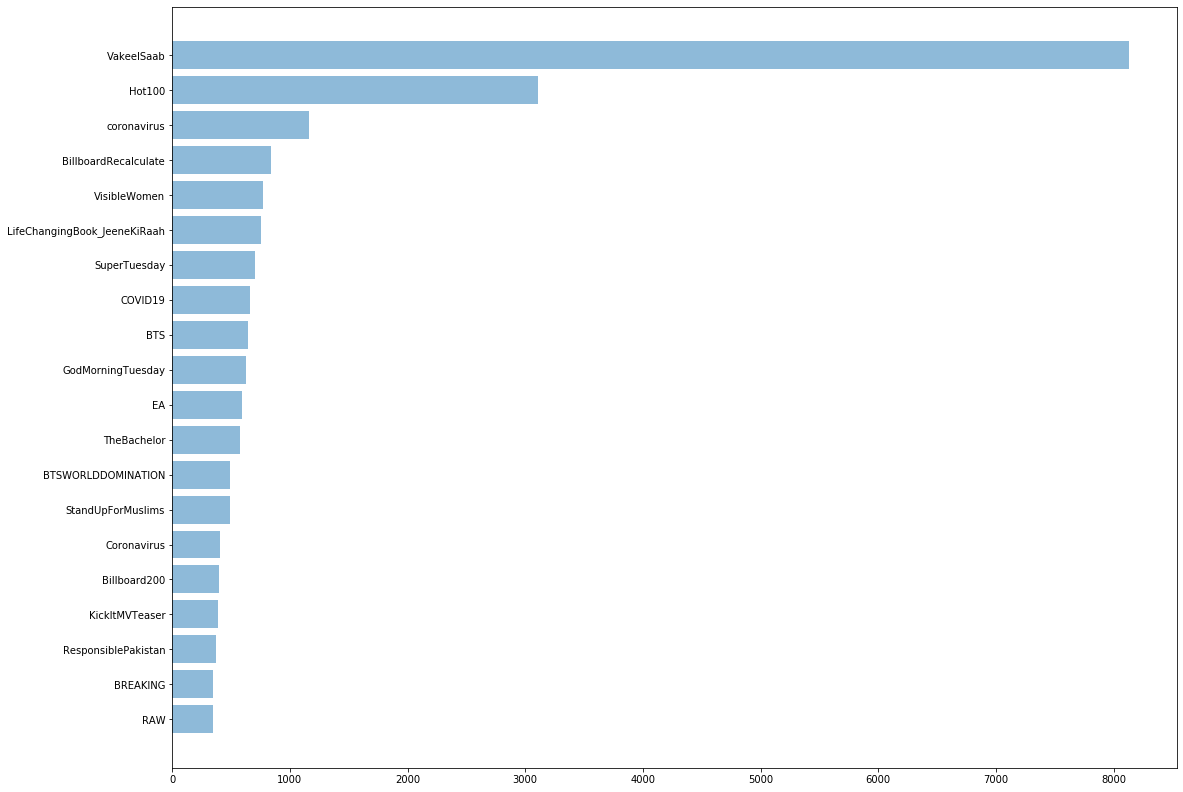

In [181]:
import matplotlib.pyplot as plt
from operator import itemgetter

names = []
counts = []
count_list = [[k,v] for k,v in hashtag_counts.items()]
count_list = sorted(count_list, key=itemgetter(1),reverse=True)
[names.append(item[0]) for item in count_list[:20]]
[counts.append(item[1]) for item in count_list[:20]]

name_ticks = np.arange(0,len(names))+0.55

plt.figure(figsize=(18,14))
plt.barh(name_ticks, counts, align='center', alpha=0.5)
plt.yticks(name_ticks, names)
plt.gca().invert_yaxis()
plt.show()

## 3.2 Recombine the filtered tweets

In [73]:
cleaned_tweets  = []
for tt in final_df["text"]:
    cleaned_tweet = " ".join(w for w in tt if len(w) > 2 and w.isalpha())
    cleaned_tweets.append(cleaned_tweet)
cleaned_tweets

['recordingacad bts twt landed hit billboard digital sale chart single little radio play',
 'bangalore dfc karnan today anandavikatan exclusive dhanushkraja mari selvaraj thevcreations music santhosh',
 'amandatammi favorite part wednesday chicagopd one',
 'twin sight sore eye mntwins',
 'new superfan enjoying posting sneak peek see full version',
 'spho magg outside crush tonight rhodeswedding',
 'lrdadrean wweforever guy wanted car high jump jenontahir finewayz gobands',
 'dsavy sacrifice holly respect cbjvscgy',
 'sceneryfortae inner child achieved itunes far bts side track highest number',
 'love playing hockey game need bigger hockey game table watch video',
 'holiwithamazon amazonin done',
 'jacksfilms watch doin mom fatty spin hour reading answer yiay',
 'papermagazine still screaming bts',
 'jaemjenarchive thedreamshowinmanila according brought slogan spotting telling',
 'spindleyear volume control dial stuck eleven bright smile brighter laughter bundled energy even leth',
 're

# 4. Apply TF-IDF & Kmeans to Cluster Tweets' Topic

In [164]:
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)  
feature_names = tfidf_vectorizer.get_feature_names() # num phrases  

from sklearn.cluster import KMeans
num_clusters = 6
km = KMeans(n_clusters=num_clusters)  
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()  

In [165]:
cluster_df = pd.DataFrame()
cluster_df['ClusterID'] = clusters  
print(cluster_df['ClusterID'].value_counts())

0    73167
3     8016
5     2376
2     1309
4     1160
1      496
Name: ClusterID, dtype: int64


In [166]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster {} : Words :".format(i))
    for ind in order_centroids[i, :6]: 
        print(' %s' % feature_names[ind])

Cluster 0 : Words :
 amp
 new
 one
 day
 love
 like
Cluster 1 : Words :
 nct
 neo zone
 neo
 zone
 nct kick music
 kick music
Cluster 2 : Words :
 billboard
 bts
 bts twt
 twt
 billboard bts
 map soul
Cluster 3 : Words :
 vakeelsaab
 tweet
 speed
 min
 tweet vakeelsaab
 needed
Cluster 4 : Words :
 billboardcharts hot top
 dated march
 top chart dated
 hot top chart
 billboardcharts hot
 chart dated
Cluster 5 : Words :
 billboardcharts bts
 billboardcharts bts twt
 liluzivert cover
 billboardcharts
 bts
 bts twt


# 5. Apply LDA to Cluster Tweets' Topic

In [90]:
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

texts = [text for text in cleaned_tweets if len(text) > 2]
doc_clean = [clean(doc).split() for doc in texts]
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
ldamodel = models.ldamodel.LdaModel(doc_term_matrix, num_topics=6, id2word = 
dictionary, passes=5)

for topic in ldamodel.show_topics(num_topics=6, formatted=False, num_words=6):
    print("Topic {}: Words: ".format(topic[0]))
    topicwords = [w for (w, val) in topic[1]]
    print(topicwords)

Topic 0: Words: 
['vakeelsaab', 'amp', 'tweet', 'love', 'look', 'fan']
Topic 1: Words: 
['one', 'vote', 'day', 'today', 'supertuesday', 'lifechangingbook']
Topic 2: Words: 
['coronavirus', 'new', 'amp', 'right', 'get', 'covid']
Topic 3: Words: 
['video', 'kickitmvteaser', 'nct', 'nctsmtown', 'music', 'boy']
Topic 4: Words: 
['march', 'new', 'top', 'release', 'hot', 'hit']
Topic 5: Words: 
['bts', 'week', 'twt', 'song', 'chart', 'million']


In [91]:
import gensim
from gensim.models.doc2vec import TaggedDocument
taggeddocs = []
tag2tweetmap = {}
for index,i in enumerate(cleaned_tweets):
    if len(i) > 2: # Non empty tweets
        tag = u'SENT_{:d}'.format(index)
        sentence = TaggedDocument(words=gensim.utils.to_unicode(i).split(), tags=[tag])
        tag2tweetmap[tag] = i
        taggeddocs.append(sentence)
        

model = gensim.models.Doc2Vec(taggeddocs, dm=0, alpha=0.025, size=20, 
min_alpha=0.025, min_count=0)
for epoch in range(60):
    if epoch % 20 == 0:
        print('Now training epoch %s' % epoch)
    model.train(taggeddocs, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


Now training epoch 0


C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Now training epoch 20
Now training epoch 40


In [170]:
from sklearn.cluster import KMeans

dataSet = model.docvecs.doctag_syn0
kmeansClustering = KMeans(n_clusters=5)
centroidIndx = kmeansClustering.fit_predict(dataSet)
topic2wordsmap = {}
for i, val in enumerate(dataSet):
    tag = model.docvecs.index_to_doctag(i)
#     print(i,':',tag)
    topic = centroidIndx[i]
#     print(topic)
    if topic in topic2wordsmap.keys():
        for w in (tag2tweetmap[tag].split()):
            topic2wordsmap[topic].append(w)
    else:
        topic2wordsmap[topic] = []
for i in topic2wordsmap:
    words = topic2wordsmap[i]
    print("Topic {} has words {}".format(i, words[:6]))

C:\Users\72809\miniconda3\envs\EE260\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Topic 4 has words ['bighitent', 'bts', 'surprise', 'drop', 'new', 'music']
Topic 2 has words ['amandatammi', 'favorite', 'part', 'wednesday', 'chicagopd', 'one']
Topic 3 has words ['new', 'superfan', 'enjoying', 'posting', 'sneak', 'peek']
Topic 1 has words ['love', 'playing', 'hockey', 'game', 'need', 'bigger']
Topic 0 has words ['first', 'selfie', 'holi', 'trendpspk', 'motion', 'poster']


In [184]:
finalist = final_df['hashtags'].tolist()
finalist[0][0].lower()

'on'